### Here we are going to train out ML models on prepared data set and then make predictions for Item Quantiy ordered for each Menu Item using Classification models.

### Note : We will be using the Predictions data set generated earlier for Menu Items and will try to predict Item Quantity for those Menu Items for the time periord of 1st July,2019 to 7th July,2019.

In [1]:
from pycaret.regression import *
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings(action='ignore')

In [2]:
data = pd.read_excel("prepared_data.xlsx")

In [3]:
final_data = data.drop(columns=['Date'])
final_data.head()

,Day,Day Type,Shift,MenuCategory,MenuItem,ItemQty
0,Tuesday,Weekday,Lunch,Starter,GOBI MANCHURIAN,1
1,Tuesday,Weekday,Lunch,Starter,TASTY FLATBREAD,1
2,Tuesday,Weekday,Lunch,VEGETABLE SPECIALS,SARSON DA SAAG,1
3,Tuesday,Weekday,Lunch,VEGETABLE SPECIALS,PANEER VINDALOO,1
4,Tuesday,Weekday,Lunch,BREADS,GARLIC NAAN,2


In [4]:
print(final_data.shape)
print(final_data.describe())
print(final_data.info())

(22038, 6)
            ItemQty
count  22038.000000
mean       1.695707
std        0.896095
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22038 entries, 0 to 22037
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Day           22038 non-null  object
 1   Day Type      22038 non-null  object
 2   Shift         22038 non-null  object
 3   MenuCategory  22038 non-null  object
 4   MenuItem      22038 non-null  object
 5   ItemQty       22038 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.0+ MB
None


### We are going to remove some rows which contain below specified Menu Items as they are not present in our Test data generated from Predictions for Menu Items since this would cause problem while predicting for Test set.

In [5]:
cols_remove = ['ALOO PARATHA', 'VEGETABLE PAKORA', 'FISH PAKORA','SPICY CHICKEN BITES', 'MASALA CHICKEN WINGS',
               'BUTTER CHICKEN','TASTY FLATBREAD', 'BAINGAN BARTHA']

print(final_data.shape)
final_data.drop(final_data[final_data['MenuItem'].isin(cols_remove)].index, inplace = True)
print(final_data.shape)

(22038, 6)
(18914, 6)


<Figure size 1080x1440 with 0 Axes>

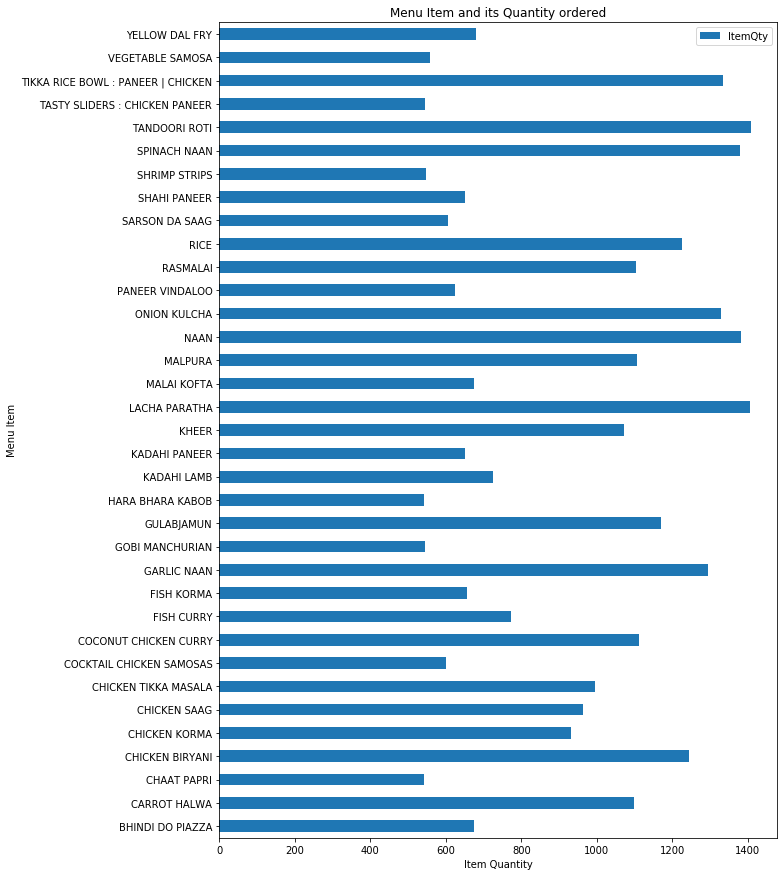

In [81]:
''' Plotting value counts of each Menu Item ordered '''
fig = plt.figure(figsize=(15,20))
final_data.groupby(['MenuItem']).agg({"ItemQty":'sum'}).plot.barh(figsize=(10,15))
plt.title('Menu Item and its Quantity ordered')
plt.xlabel('Item Quantity')
plt.ylabel('Menu Item')
plt.show()

### First we will be going with regular approach of preparing our data for our models by performing various steps like dummy encdoing, Train - Test data splitting and Initializing various models and then performing  fit() & predict() methods on our models and check their outputs.

In [7]:
prepared_data = pd.get_dummies(data=final_data,columns=['Shift','Day','Day Type','MenuCategory','MenuItem'],drop_first=True)
prepared_data.head()

,ItemQty,Shift_Lunch,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Day Type_Weekend,MenuCategory_CHICKEN SPECIALS,...,MenuItem_RICE,MenuItem_SARSON DA SAAG,MenuItem_SHAHI PANEER,MenuItem_SHRIMP STRIPS,MenuItem_SPINACH NAAN,MenuItem_TANDOORI ROTI,MenuItem_TASTY SLIDERS : CHICKEN PANEER,MenuItem_TIKKA RICE BOWL : PANEER | CHICKEN,MenuItem_VEGETABLE SAMOSA,MenuItem_YELLOW DAL FRY
0,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_features = prepared_data.iloc[:,1:].values
Y_features = prepared_data.iloc[:,0].values

In [9]:
X_features.shape , Y_features.shape

((18914, 49), (18914,))

### Note : Over Sampling our data using SMOTE to improve model performance

In [10]:
from collections import Counter

print(Counter(Y_features))

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_features_sampled,Y_features_sampled = oversample.fit_resample(X_features,Y_features)

print(Counter(Y_features_sampled))

Counter({1: 10397, 2: 4709, 3: 2889, 4: 919})


Using TensorFlow backend.


Counter({1: 10397, 2: 10397, 3: 10397, 4: 10397})


In [11]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

x_train,x_test,y_train,y_test = train_test_split(X_features_sampled,Y_features_sampled,test_size=0.25,random_state=42)

In [12]:
from xgboost import XGBClassifier

xgb = XGBClassifier(base_score=0.5, booster='gbtree',
                        colsample_bylevel=1,
                        colsample_bynode=1,
                        colsample_bytree=1, gamma=0,
                        learning_rate=0.1, max_delta_step=0,
                        max_depth=3, min_child_weight=1,
                        missing=None, n_estimators=100,
                        n_jobs=-1, nthread=None,
                        objective='binary:logistic',
                        random_state=42, reg_alpha=0,
                        reg_lambda=1, scale_pos_weight=1,
                        seed=None, silent=None, subsample=1,
                        verbosity=0)

xgb.fit(x_train,y_train)

y_pred_xgb = xgb.predict(x_test)

In [13]:
print("R2 Score :",metrics.r2_score(y_test,y_pred_xgb))
print("MAE Score :",metrics.mean_absolute_error(y_test,y_pred_xgb))
print("RMSE Score :",np.sqrt(metrics.mean_squared_error(y_test,y_pred_xgb)))

R2 Score : -0.8250143266870822
MAE Score : 1.1134942771953449
RMSE Score : 1.5089422785641844


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True,
                                 ccp_alpha=0.0,
                                 class_weight=None,
                                 criterion='entropy',
                                 max_depth=10,
                                 max_features='log2',
                                 max_leaf_nodes=None,
                                 max_samples=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 min_samples_leaf=4,
                                 min_samples_split=10,
                                 min_weight_fraction_leaf=0.0,
                                 n_estimators=300,
                                 n_jobs=None,
                                 oob_score=False,
                                 random_state=42, verbose=0,
                                 warm_start=False)

rf.fit(x_train,y_train)

y_pred_rf = rf.predict(x_test)

In [15]:
print("R2 Score :",metrics.r2_score(y_test,y_pred_rf))
print("MAE Score :",metrics.mean_absolute_error(y_test,y_pred_rf))
print("RMSE Score :",np.sqrt(metrics.mean_squared_error(y_test,y_pred_rf)))

R2 Score : -0.45142334003031714
MAE Score : 0.9907665672790228
RMSE Score : 1.34566370643293


In [16]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(C=3.948, class_weight=None,
                             dual=False, fit_intercept=True,
                             intercept_scaling=1,
                             l1_ratio=None, max_iter=100,
                             multi_class='auto',
                             n_jobs=None, penalty='l2',
                             random_state=42,
                             solver='lbfgs', tol=0.0001,
                             verbose=0, warm_start=False)

lr_clf.fit(x_train,y_train)

y_pred_lr = lr_clf.predict(x_test)

In [17]:
print("R2 Score :",metrics.r2_score(y_test,y_pred_lr))
print("MAE Score :",metrics.mean_absolute_error(y_test,y_pred_lr))
print("RMSE Score :",np.sqrt(metrics.mean_squared_error(y_test,y_pred_lr)))

R2 Score : -0.5062362148782247
MAE Score : 1.011060882947004
RMSE Score : 1.3708376716083301


### As we can examine from outputs of various classification models, overall performance of XGBOOST is higher than others.

### So we will be using XGBOOST model as our final model for predictions on test set.

In [18]:
''' Loading data set containing predictions for Menu Items which will be used as Test set here for predicting Item Quantity '''
load_test_data = pd.read_excel('Predicted_MenuItems.xlsx')
test_data= load_test_data.drop(columns=['Date'])
test_data.head(10)

,Day,Day Type,Shift,MenuCategory,MenuItem
0,Monday,Weekday,Lunch,DESSERTS,GULABJAMUN
1,Monday,Weekday,Lunch,BREADS,TANDOORI ROTI
2,Monday,Weekday,Lunch,BREADS,TANDOORI ROTI
3,Monday,Weekday,Lunch,VEGETABLE SPECIALS,SHAHI PANEER
4,Monday,Weekday,Lunch,CHICKEN SPECIALS,CHICKEN TIKKA MASALA
5,Monday,Weekday,Lunch,SEAFOOD SPECIALTIES,FISH CURRY
6,Monday,Weekday,Lunch,VEGETABLE SPECIALS,SHAHI PANEER
7,Monday,Weekday,Lunch,BREADS,TANDOORI ROTI
8,Monday,Weekday,Lunch,Starter,COCKTAIL CHICKEN SAMOSAS
9,Monday,Weekday,Lunch,BREADS,TANDOORI ROTI


In [19]:
''' Transforming test data as well before feeding into ML model '''
prepared_test_data = pd.get_dummies(data=test_data,columns=['Shift','Day','Day Type','MenuCategory','MenuItem'],drop_first=True)
prepared_test_data.head()

,Shift_Lunch,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Day Type_Weekend,MenuCategory_CHICKEN SPECIALS,MenuCategory_DESSERTS,...,MenuItem_RICE,MenuItem_SARSON DA SAAG,MenuItem_SHAHI PANEER,MenuItem_SHRIMP STRIPS,MenuItem_SPINACH NAAN,MenuItem_TANDOORI ROTI,MenuItem_TASTY SLIDERS : CHICKEN PANEER,MenuItem_TIKKA RICE BOWL : PANEER | CHICKEN,MenuItem_VEGETABLE SAMOSA,MenuItem_YELLOW DAL FRY
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
''' Predicting values on Test set '''
model_predictions = xgb.predict(prepared_test_data.values)
model_predictions[0:20]

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [22]:
load_test_data['ItemQty'] = model_predictions
load_test_data.head(10)

,Date,Day,Day Type,Shift,MenuCategory,MenuItem,ItemQty
0,2019-07-01,Monday,Weekday,Lunch,DESSERTS,GULABJAMUN,1
1,2019-07-01,Monday,Weekday,Lunch,BREADS,TANDOORI ROTI,1
2,2019-07-01,Monday,Weekday,Lunch,BREADS,TANDOORI ROTI,1
3,2019-07-01,Monday,Weekday,Lunch,VEGETABLE SPECIALS,SHAHI PANEER,1
4,2019-07-01,Monday,Weekday,Lunch,CHICKEN SPECIALS,CHICKEN TIKKA MASALA,1
5,2019-07-01,Monday,Weekday,Lunch,SEAFOOD SPECIALTIES,FISH CURRY,2
6,2019-07-01,Monday,Weekday,Lunch,VEGETABLE SPECIALS,SHAHI PANEER,1
7,2019-07-01,Monday,Weekday,Lunch,BREADS,TANDOORI ROTI,1
8,2019-07-01,Monday,Weekday,Lunch,Starter,COCKTAIL CHICKEN SAMOSAS,1
9,2019-07-01,Monday,Weekday,Lunch,BREADS,TANDOORI ROTI,1


In [82]:
''' Exporting final results into an excel file '''
load_test_data.to_excel('final_predicted_data.xlsx')

## Final Analysis on our Predicted data

In [50]:
''' Grouping our data by date ,shift and MenuItem and then taking sum of ItemQty to see datewise distribution of data '''
predicted_data = load_test_data.groupby(['Date','Shift','MenuItem'])['ItemQty'].sum()
print(predicted_data.head(35))

Date        Shift   MenuItem                          
2019-07-01  Dinner  CHICKEN KORMA                          6
                    COCKTAIL CHICKEN SAMOSAS               6
                    FISH CURRY                             4
                    GULABJAMUN                             8
                    KADAHI LAMB                            1
                    LACHA PARATHA                         11
                    MALAI KOFTA                            8
                    TIKKA RICE BOWL : PANEER | CHICKEN     5
            Lunch   CHICKEN TIKKA MASALA                  14
                    COCKTAIL CHICKEN SAMOSAS               8
                    FISH CURRY                             6
                    GULABJAMUN                             8
                    SHAHI PANEER                          11
                    TANDOORI ROTI                         17
                    TIKKA RICE BOWL : PANEER | CHICKEN     7
2019-07-02  Dinner  CHICKEN BI

In [57]:
''' Splitting our data into Lunch and Dinner data sets '''
lunch_data = load_test_data[load_test_data['Shift'] == 'Lunch']
dinner_data = load_test_data[load_test_data['Shift'] == 'Dinner']

In [64]:
''' Getting top Menu Item with its Quantity ordered for Lunch Timings '''
top_lunch_item = lunch_data.groupby(['Shift','MenuItem']).agg({'ItemQty':'sum'}).sort_values('ItemQty',ascending=False)
top_lunch_item

ItemQty
Shift MenuItem                                   
Lunch SPINACH NAAN                             94
      COCONUT CHICKEN CURRY                    85
      SHRIMP STRIPS                            51
      KHEER                                    38
      TIKKA RICE BOWL : PANEER | CHICKEN       30
      FISH KORMA                               29
      GARLIC NAAN                              26
      KADAHI PANEER                            25
      GOBI MANCHURIAN                          24
      LACHA PARATHA                            24
      BHINDI DO PIAZZA                         24
      ONION KULCHA                             22
      CARROT HALWA                             21
      NAAN                                     21
      VEGETABLE SAMOSA                         20
      RASMALAI                                 18
      TANDOORI ROTI                            17
      GULABJAMUN                               17
      CHICKEN BIRYANI                          15
      FISH CURRY                               14
      PANEER VINDALOO                          14
      CHICKEN TIKKA MASALA                     14
      KADAHI LAMB                              13
      HARA BHARA KABOB                         12
      MALPURA                                  11
      SHAHI PANEER                             11
      CHICKEN KORMA                            11
      RICE                                     10
      COCKTAIL CHICKEN SAMOSAS                  8
      SARSON DA SAAG                            8
      TASTY SLIDERS : CHICKEN PANEER            7

In [65]:
''' Getting top Menu Item with its Quantity ordered for Dinner Timings '''
top_dinner_item = dinner_data.groupby(['Shift','MenuItem']).agg({'ItemQty':'sum'}).sort_values('ItemQty',ascending=False)
top_dinner_item

ItemQty
Shift  MenuItem                                   
Dinner MALAI KOFTA                              39
       NAAN                                     36
       COCKTAIL CHICKEN SAMOSAS                 36
       LACHA PARATHA                            34
       CHICKEN SAAG                             30
       KHEER                                    30
       SHRIMP STRIPS                            27
       RICE                                     22
       SPINACH NAAN                             22
       GULABJAMUN                               21
       RASMALAI                                 21
       YELLOW DAL FRY                           21
       TIKKA RICE BOWL : PANEER | CHICKEN       19
       CHICKEN KORMA                            17
       CHICKEN TIKKA MASALA                     16
       GOBI MANCHURIAN                          15
       TANDOORI ROTI                            15
       COCONUT CHICKEN CURRY                    14
       FISH CURRY                               12
       KADAHI LAMB                              11
       FISH KORMA                               10
       CHAAT PAPRI                               6
       BHINDI DO PIAZZA                          6
       CHICKEN BIRYANI                           4

<Figure size 720x1080 with 0 Axes>

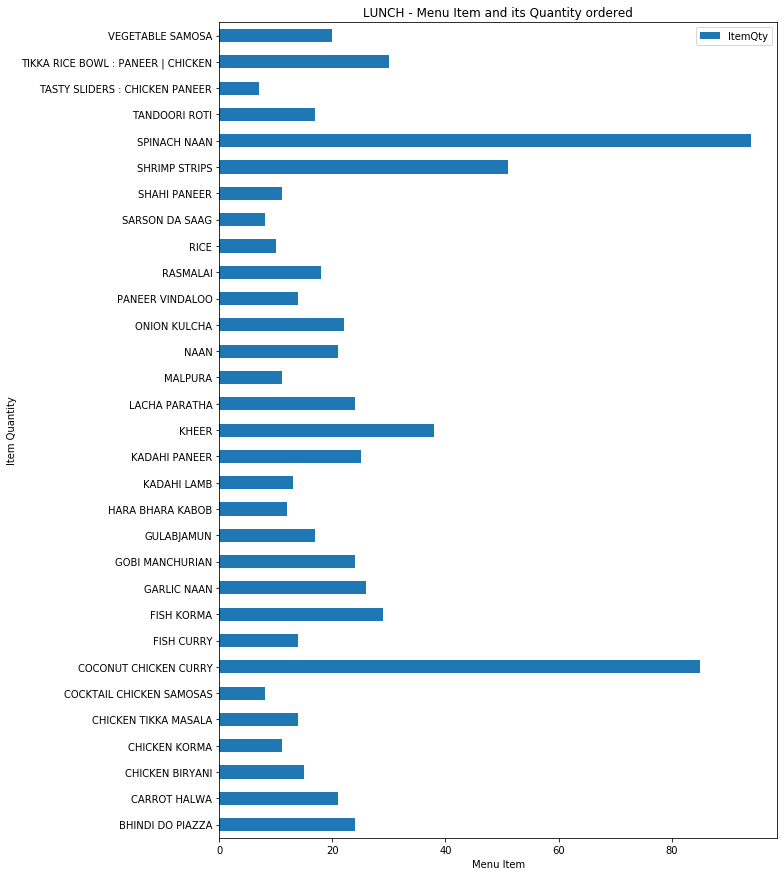

In [74]:
''' Plot for Lunch Sales '''
lunch_data.groupby(['MenuItem']).agg({'ItemQty':'sum'}).plot.barh(figsize=(10,15))
plt.title('LUNCH - Menu Item and its Quantity ordered')
plt.ylabel('Item Quantity')
plt.xlabel('Menu Item')
plt.show()

<Figure size 720x1080 with 0 Axes>

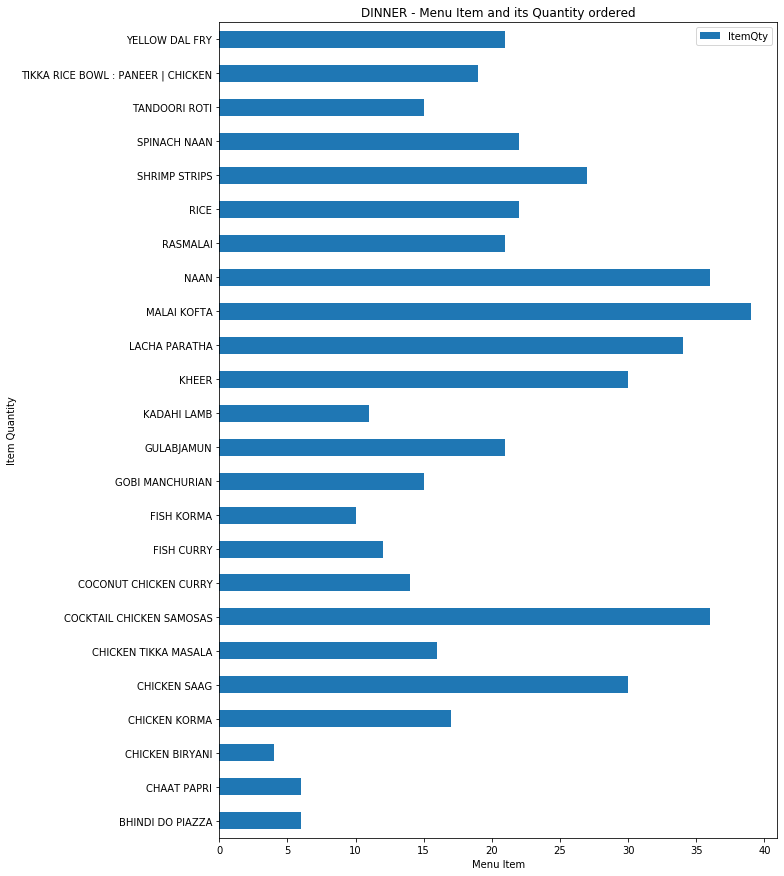

In [73]:
''' Plot for Dinner Sales '''
dinner_data.groupby(['MenuItem']).agg({'ItemQty':'sum'}).plot.barh(figsize=(10,15))
plt.title('DINNER - Menu Item and its Quantity ordered')
plt.ylabel('Item Quantity')
plt.xlabel('Menu Item')
plt.show()

# Hence it can be analysed from above tables and plots that:

## Top Lunch Menu Item & Quantity = 'SPINACH NAAN'	& 94.

## Top Dinner Menu Item & Quantity = 'MALAI KOFTA' & 39.

In [75]:
gc.collect()

157533